### Imports

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import cross_val_score, cross_val_predict, StratifiedKFold
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from imblearn.combine import SMOTETomek
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.metrics import confusion_matrix
from sklearn.preprocessing import StandardScaler

### Read Train Data Set

In [3]:
df = pd.read_csv("cleaned_train.csv")

In [4]:
X = df.drop(columns=["Credit_Score"]) 
y = df["Credit_Score"] 

# Split the dataset into 80% training and 20% validation
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

### Balance Dataset

C:\Users\User\AppData\Local\Temp\ipykernel_10532\1660456265.py:17: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=original_df.index, y=original_df['Count'], palette="Blues", ax=axes[0])
C:\Users\User\AppData\Local\Temp\ipykernel_10532\1660456265.py:23: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=resampled_df.index, y=resampled_df['Count'], palette="Oranges", ax=axes[1])


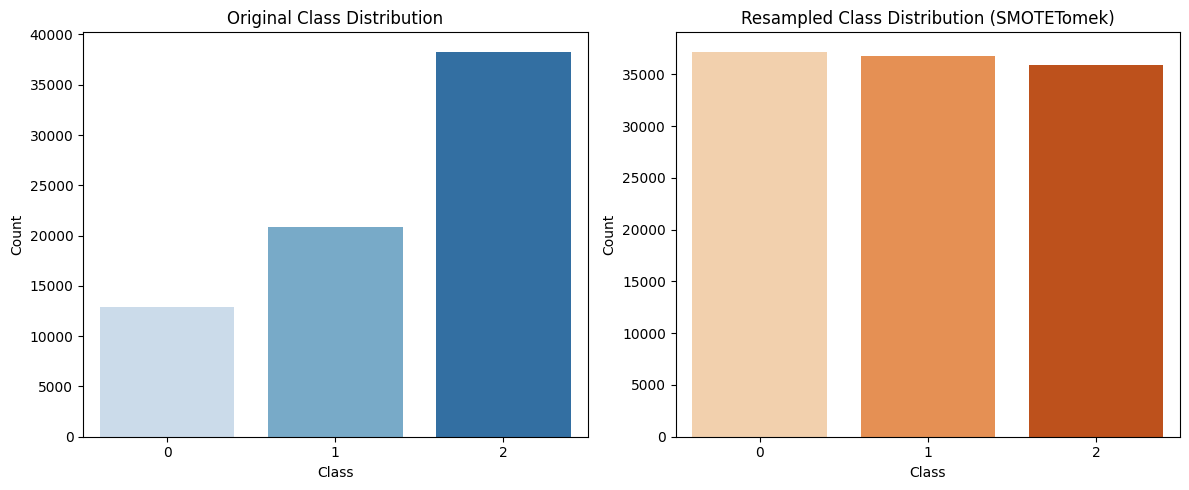

In [5]:
# Apply SMOTEENN
sample = SMOTETomek(random_state=139)
X_train_resampled, y_train_resampled = sample.fit_resample(X_train, y_train)

# Count class distribution
original_counts = Counter(y_train)
resampled_counts = Counter(y_train_resampled)

# Convert to DataFrame for plotting
original_df = pd.DataFrame.from_dict(original_counts, orient='index', columns=['Count'])
resampled_df = pd.DataFrame.from_dict(resampled_counts, orient='index', columns=['Count'])

# Plot original vs resampled distributions
fig, axes = plt.subplots(1, 2, figsize=(12, 5))

# Original Data Distribution
sns.barplot(x=original_df.index, y=original_df['Count'], palette="Blues", ax=axes[0])
axes[0].set_title("Original Class Distribution")
axes[0].set_xlabel("Class")
axes[0].set_ylabel("Count")

# Resampled Data Distribution
sns.barplot(x=resampled_df.index, y=resampled_df['Count'], palette="Oranges", ax=axes[1])
axes[1].set_title("Resampled Class Distribution (SMOTETomek)")
axes[1].set_xlabel("Class")
axes[1].set_ylabel("Count")

plt.tight_layout()
plt.show()

### Decision Tree

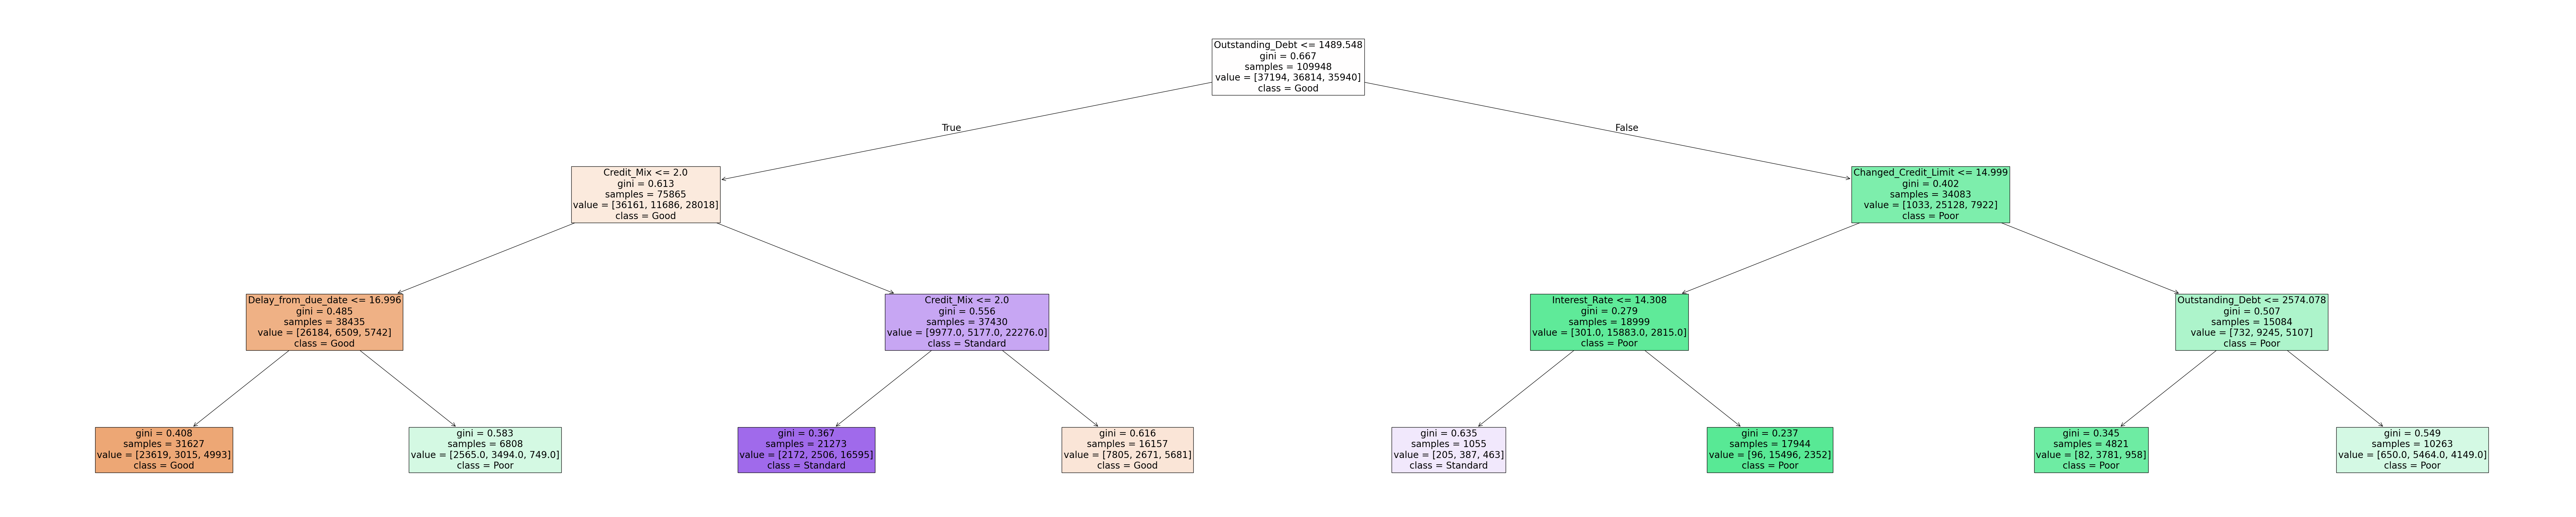

In [6]:
dt_model = DecisionTreeClassifier(max_depth=3, random_state=42)
dt_model.fit(X_train_resampled, y_train_resampled)

class_mapping = {0: "Good", 1: "Poor", 2: "Standard"}

class_names = [class_mapping[i] for i in sorted(class_mapping.keys())]

plt.figure(figsize=(100, 20))
plot_tree(
    dt_model, 
    feature_names=X.columns, 
    class_names=class_mapping,
    filled=True, 
    fontsize=20, 
)
plt.show()

### Train Models

In [7]:
knn_model = KNeighborsClassifier(n_neighbors=5)  
knn_model.fit(X_train_resampled, y_train_resampled)

naive_model = GaussianNB()
naive_model.fit(X_train_resampled, y_train_resampled)

GaussianNB()

In [8]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_resampled)
X_test_scaled = scaler.transform(X_val)

# Train SVM
svm_model = SVC()
svm_model.fit(X_train_scaled, y_train_resampled)

SVC()

##### Evaluate Function

In [9]:
def evaluate_model(model, X, y, name, cv=10):
    skf = StratifiedKFold(n_splits=cv, shuffle=True, random_state=42)

    accuracy = cross_val_score(model, X, y, cv=skf, scoring="accuracy")
    precision = cross_val_score(model, X, y, cv=skf, scoring="precision_weighted")
    recall = cross_val_score(model, X, y, cv=skf, scoring="recall_weighted")
    roc_auc = cross_val_score(model, X, y, cv=skf, scoring="roc_auc_ovr") if hasattr(model, "predict_proba") else ["N/A"] * cv

    y_pred = cross_val_predict(model, X, y, cv=skf)

    conf_matrix = confusion_matrix(y, y_pred)

    class_names = {0: "Good", 1: "Poor", 2: "Standard"} 

    # Print evaluation metrics
    print(f"\n\n=================== {name} MODEL 10-FOLD CROSS-VALIDATION ===================")
    print(f"Mean Accuracy: {np.mean(accuracy):.4f} ± {np.std(accuracy):.4f}")
    print(f"Mean Precision: {np.mean(precision):.4f}")
    print(f"Mean Recall: {np.mean(recall):.4f}")
    print(f"Mean ROC-AUC Score: {np.mean(roc_auc) if roc_auc[0] != 'N/A' else 'N/A'}")

    # Plot confusion matrix
    plt.figure(figsize=(6, 5))
    sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=class_names.values(), yticklabels=class_names.values())
    plt.xlabel("Predicted Label")
    plt.ylabel("True Label")
    plt.title(f"Confusion Matrix - {name}")
    plt.show()

### Evaluate Models



=================== Naive Bayes MODEL 10-FOLD CROSS-VALIDATION ===================
Mean Accuracy: 0.5197 ± 0.0102
Mean Precision: 0.5201
Mean Recall: 0.5197
Mean ROC-AUC Score: 0.661091408994288


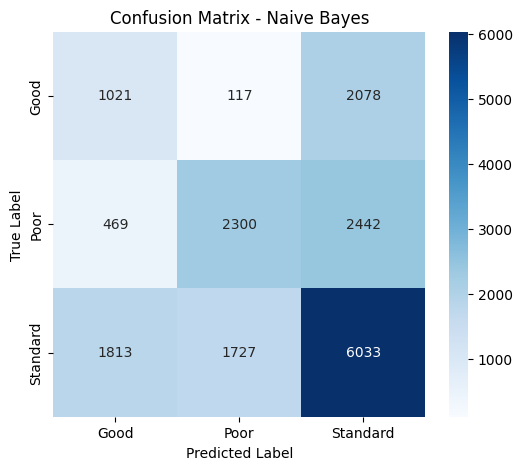



=================== KNN Model MODEL 10-FOLD CROSS-VALIDATION ===================
Mean Accuracy: 0.5877 ± 0.0141
Mean Precision: 0.5849
Mean Recall: 0.5877
Mean ROC-AUC Score: 0.733036608182912


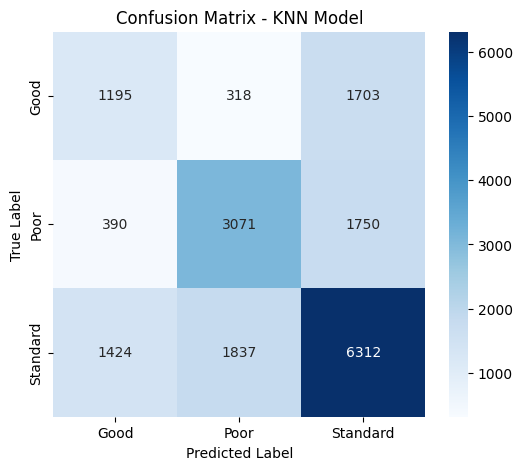



=================== Support Vector Machine MODEL 10-FOLD CROSS-VALIDATION ===================
Mean Accuracy: 0.6504 ± 0.0076
Mean Precision: 0.6633
Mean Recall: 0.6504
Mean ROC-AUC Score: N/A


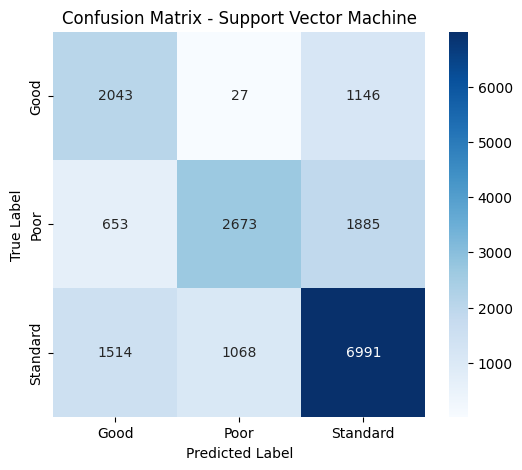

In [10]:
evaluate_model(naive_model, X_val, y_val, "Naive Bayes" )
evaluate_model(knn_model, X_val, y_val, "KNN Model")
evaluate_model(svm_model, X_test_scaled, y_val, "Support Vector Machine" )

### Validation on Unseen Data



=================== Naive Bayes MODEL 10-FOLD CROSS-VALIDATION ===================
Mean Accuracy: 0.5141 ± 0.0116
Mean Precision: 0.5050
Mean Recall: 0.5141
Mean ROC-AUC Score: 0.6530067801976568


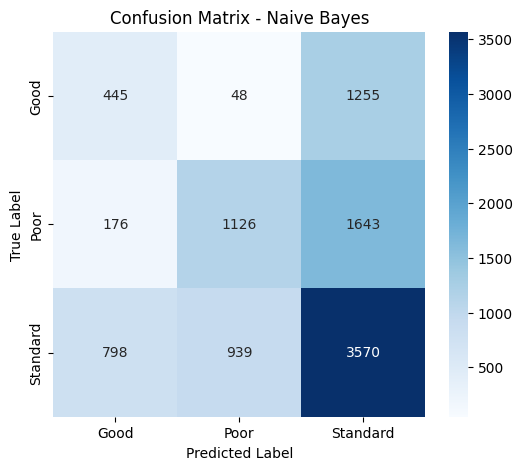



=================== KNN Model MODEL 10-FOLD CROSS-VALIDATION ===================
Mean Accuracy: 0.5537 ± 0.0157
Mean Precision: 0.5489
Mean Recall: 0.5537
Mean ROC-AUC Score: 0.6997701301085926


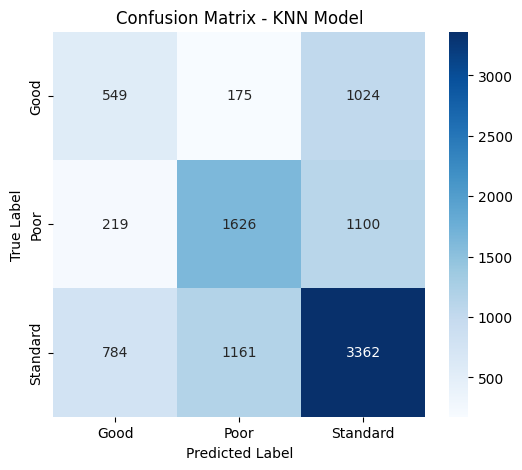



=================== Support Vector Machine MODEL 10-FOLD CROSS-VALIDATION ===================
Mean Accuracy: 0.6479 ± 0.0142
Mean Precision: 0.6591
Mean Recall: 0.6479
Mean ROC-AUC Score: N/A


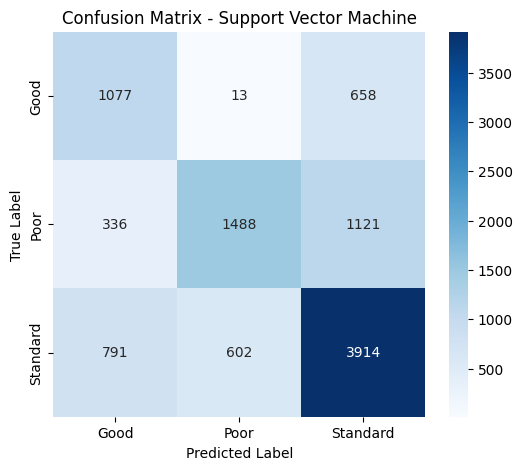

In [11]:
unseen_df = pd.read_csv('cleaned_unseen.csv')

X_unseen = unseen_df.drop(columns=["Credit_Score"])
y_unseen = unseen_df["Credit_Score"]
X_unseen_scaled = scaler.transform(X_unseen)

evaluate_model(naive_model, X_unseen, y_unseen, "Naive Bayes" )
evaluate_model(knn_model, X_unseen, y_unseen, "KNN Model" )
evaluate_model(svm_model, X_unseen_scaled, y_unseen, "Support Vector Machine" )